In [1]:
from typing import Callable

import matplotlib.pyplot as plt
import modred as mr
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch.utils.data import DataLoader

from src.models import MLP
from src.solvers.fem import Poisson1D, HelmholtzImpedance1D, ParameterizedSolver
from src.utils.helpers import PairDataset

In [2]:
sns.set_theme()

In [29]:
def get_sol(u, bases):
    assert len(u) == len(bases)
    return lambda x: np.sum([u[i] * bases[i](x) for i in range(len(bases))], axis=0)

def get_der(u, bases):
    assert len(u) == len(bases)
    return lambda x: np.sum([u[i] * bases[i].deriv(1)(x) for i in range(len(bases))], axis=0)

In [30]:
def plot_bases(S, bases):

    xs = np.linspace(-1, 1, 100)
    us = []
    # MODIFY: Combine these two loops
    sols = [get_sol(S[:, j], bases) for j in range(S.shape[1])]
    for idx, sol in enumerate(sols):
        us.append(sol(xs))

    df = pd.DataFrame({
        'x': np.concatenate([xs] * len(us)),
        'u_re': np.concatenate([u.real for u in us]),
        'u_im': np.concatenate([u.imag for u in us]),
        'j': np.concatenate([np.repeat(j, len(xs)) for j in range(len(sols))]),
    })

    fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(20, 10))
    sns.lineplot(
        data=df,
        x='x',
        y='u_re',
        hue='j',
        ax=axs[0],
    )
    sns.lineplot(
        data=df,
        x='x',
        y='u_im',
        hue='j',
        ax=axs[1],
    )


# Get N solutions with random parameters

In [5]:
N_h = 51
N_bas = 100
N_trn = 300
N_val = 50

a = [
    (4. * np.pi),
    (3. * np.pi),
    # lambda x: 30,
    # lambda x: x ** 2,
    # lambda x: 1j * 20 * (x ** 4),
    # lambda x: 10 * np.exp(x),
    # lambda x: 10 * np.exp(3 * (x ** 2)),
    # lambda x: 1j * 10 * np.exp(-5 * x),
    # lambda x: 15 * np.sin(x),
    # lambda x: -10 * np.cos(3 * x),
]
M = len(a)

if False:
    solver = HelmholtzImpedance1D(k=(4. * np.pi), ga=10., gb=20., f=None, a=-1., b=+1., N=(N_h-1))
    parsolver = ParameterizedSolver(solver=solver, a=a, uc='f')
elif True:
    solver = HelmholtzImpedance1D(k=None, ga=10., gb=20., f=(lambda x: x), a=-1., b=+1., N=(N_h-1))
    parsolver = ParameterizedSolver(solver=solver, a=a, uc='k')
elif True:
    # NOTE: Solutions are wrong, needs to be checked
    solver = Poisson1D(f=lambda x: np.sin(x), k=None, N=(N_h-1))
    parsolver = ParameterizedSolver(solver=solver, a=a, uc='k')

y_bas = np.concatenate(
    [
        np.ones(shape=(1, N_bas)),
        2 * np.random.random_sample(size=(M-1, N_bas)) - 1,
    ],
    axis=0,
)
S_bas = parsolver.solve(y=y_bas)
print(f'rank(S): {np.linalg.matrix_rank(S_bas)}')

/Users/sepehr/miniconda3/envs/mcss/lib/python3.10/site-packages/scipy/special/_orthogonal.py:370: RuntimeWarning: invalid value encountered in double_scalars
  hn *= _gam(n + beta + 1.0) / _gam(n + 1) / _gam(n + ab1)
/Users/sepehr/miniconda3/envs/mcss/lib/python3.10/site-packages/scipy/special/_orthogonal.py:371: RuntimeWarning: invalid value encountered in double_scalars
  kn = _gam(2 * n + ab1) / 2.0**n / _gam(n + 1) / _gam(n + ab1)


rank(S): 15


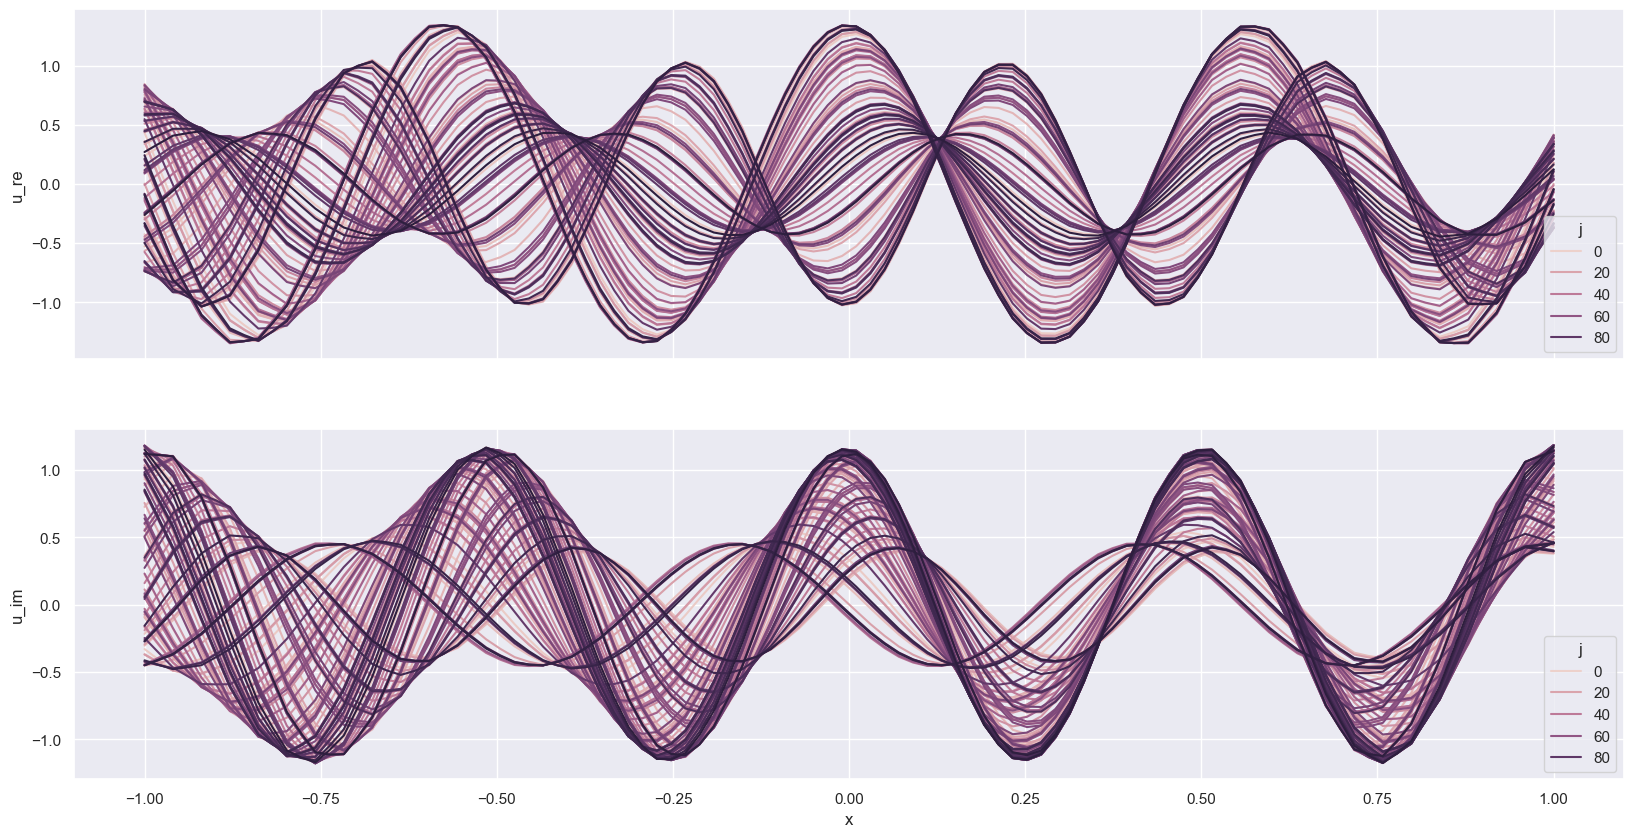

In [6]:
plot_bases(S=S_bas, bases=solver.bases)

# Get reduced basis functions

0.007394508517970713
[3.36569320e+03 7.64814949e+02 5.16864368e+01 7.90971097e-01
 1.40871514e-02 5.16370257e-04 4.30086132e-06 8.34545116e-08
 7.15276039e-10 4.87454216e-12]


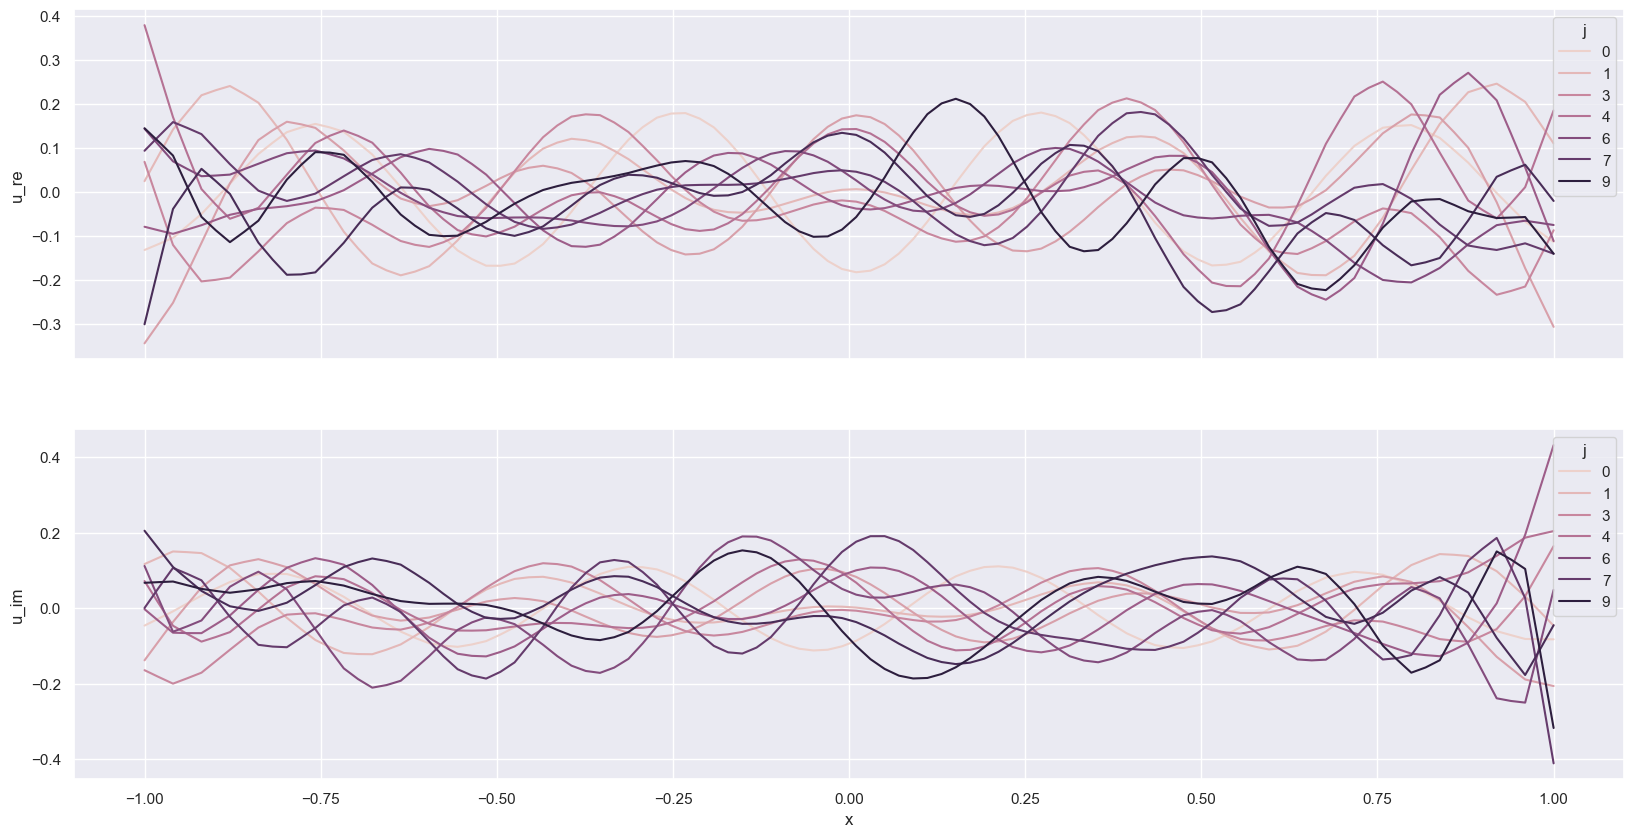

In [7]:
L = 10

assert L <= np.linalg.matrix_rank(S_bas)
pod = mr.compute_POD_arrays_snaps_method(
    S_bas,
    list(mr.range(L))
)
V = pod.modes
print(np.linalg.norm(V.conj().T @ V - np.identity(V.shape[1])))
print(pod.eigvals[:L])

plot_bases(S=V, bases=solver.bases)

# Generate train and validation data

In [8]:
y_trn = np.concatenate(
    [
        np.ones(shape=(1, N_trn)),
        2 * np.random.random_sample(size=(M-1, N_trn)) - 1,
    ],
    axis=0,
)
S_trn = parsolver.solve(y=y_trn)
c_trn = V.conj().T @ S_trn

In [9]:
y_val = np.concatenate(
    [
        np.ones(shape=(1, N_val)),
        2 * np.random.random_sample(size=(M-1, N_val)) - 1,
    ],
    axis=0,
)
S_val = parsolver.solve(y=y_val)
c_val = V.conj().T @ S_val

[Text(0.5, 1.0, 'validation'), Text(0.5, 0, '$i$')]

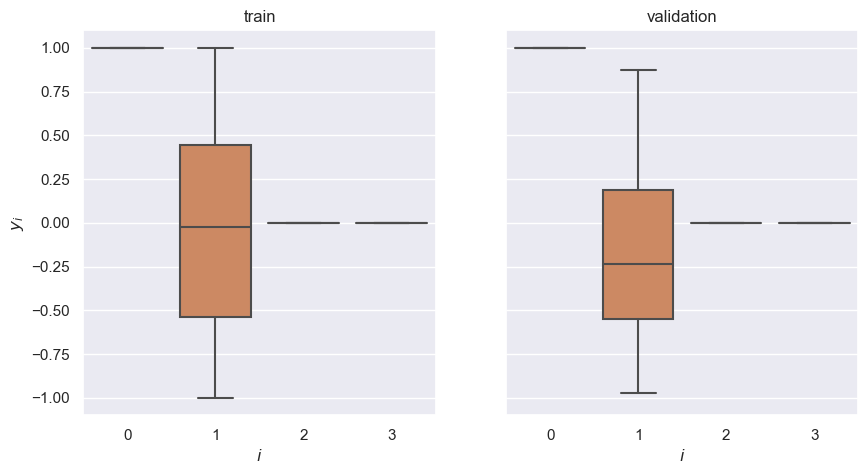

In [10]:
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10, 5))
sns.boxplot(pd.DataFrame(np.concatenate([y_trn.real, y_trn.imag]).T), ax=axs[0])
sns.boxplot(pd.DataFrame(np.concatenate([y_val.real, y_val.imag]).T), ax=axs[1])
axs[0].set(title='train', xlabel='$i$', ylabel='$y_i$')
axs[1].set(title='validation', xlabel='$i$')

# Train a model

MLP with 440 parameters
Train: 1.77e-03		Validation: 8.34e-02


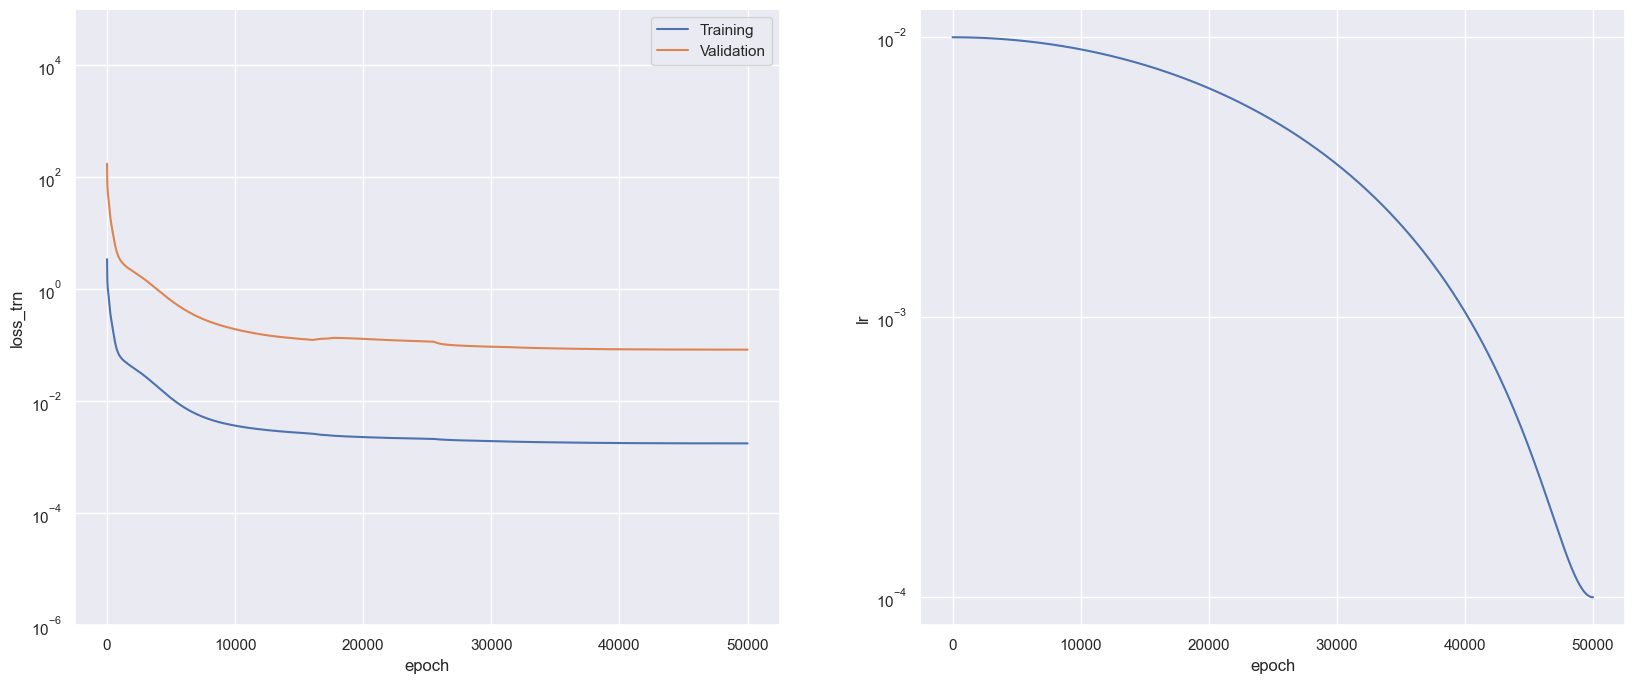

In [116]:
epochs = 50000
lr = 1e-02
wd = 0
bsz = None
batch_norm = False

if batch_norm and bsz:
    assert bsz > 1

# Define data loaders
trainloader = DataLoader(
    dataset=PairDataset(y=y_trn, c=c_trn),
    batch_size=(bsz if bsz else y_trn.shape[1]),
    shuffle=True,
    drop_last=batch_norm,
)
validationloader = DataLoader(
    dataset=PairDataset(y=y_val, c=c_val),
    batch_size=1,
    shuffle=False,
)

# Define model, criterion, and optimizer
model = MLP(
    M=M,
    L=(2 * L),  # Real and imaginary parts
    hidden_layers=[10, 10],
    activation=torch.relu,
    gain=1.,
    dtype=torch.float64,
)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=lr, momentum=.9, weight_decay=wd)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=1e-04, T_max=epochs)

# Train the model
print(f'{model.__class__.__name__} with {model.numparams()} parameters')
if True:
    stats = model.train_(
        criterion=criterion,
        epochs=epochs,
        optimizer=optimizer,
        trainloader=trainloader,
        validationloader=validationloader,
        scheduler=scheduler,
        cuda=False,
    )

    # Clean stats
    params = stats.pop('params')
    grads = stats.pop('grads')
    stats = pd.DataFrame(stats)

    # Plot the training statistics
    fig, axs = plt.subplots(1, 2, figsize=(20, 8))
    sns.lineplot(stats, x='epoch', y='loss_trn', ax=axs[0], label='Training')
    sns.lineplot(stats, x='epoch', y='loss_val', ax=axs[0], label='Validation')
    axs[0].set(yscale='log', ylim=[1e-04, 1e01])
    axs[0].legend()
    sns.lineplot(stats, x='epoch', y='lr', ax=axs[1])
    axs[1].set(yscale='log')

    # Print the final losses
    print('\t\t'.join([
        f"Train: {stats['loss_trn'].tolist()[-1]:.2e}",
        f"Validation: {stats['loss_val'].tolist()[-1]:.2e}",
    ]))

## Plot weights, biases, and outputs

In [117]:
params_ = {}
grads_ = {}
for name, vals in params.items():
    if not model.bn and 'bn' in name:
        continue
    params_[name] = {'epoch': [], 'val': []}
    for e in range(len(stats['epoch'])):
        val = vals[e].flatten()
        params_[name]['epoch'].extend([e] * len(val))
        params_[name]['val'].extend(val)
for name, vals in grads.items():
    if not model.bn and 'bn' in name:
        continue
    grads_[name] = {'epoch': [], 'val': []}
    for e in range(len(stats['epoch'])-1):
        if vals[e] is None:
            continue
        val = vals[e].flatten()
        grads_[name]['epoch'].extend([e] * len(val))
        grads_[name]['val'].extend(val)
params = {name: pd.DataFrame(params_[name]) for name in params_.keys()}
grads = {name: pd.DataFrame(grads_[name]) for name in grads_.keys()}

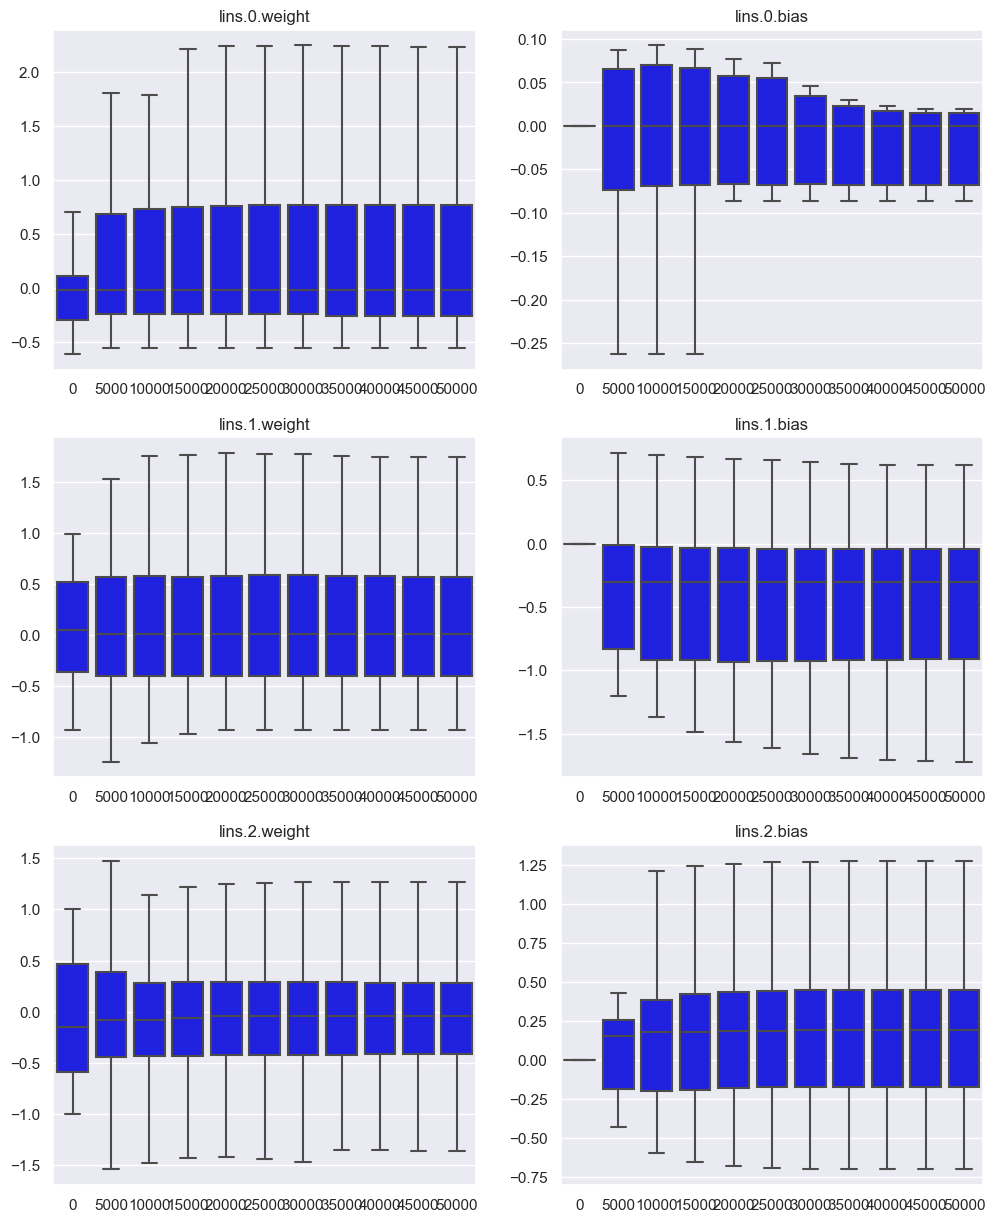

In [118]:
ncols = 2
nrows = (len(params) + 1) // ncols
fig, axs = plt.subplots(
    ncols=ncols,
    nrows=nrows,
    figsize=(12, 5 * nrows)
)
axs = axs.flatten()

for idx, (name, df) in enumerate(params.items()):
    sns.boxplot(
        data=df[
            (df['epoch'] % (epochs // 10) == 0)
            # (df['epoch'] <= 100) & (df['epoch'] % (epochs // 100) == 0)
        ],
        x='epoch', y='val',
        color='blue',
        showfliers=False,
        ax=axs[idx],
    )

    axs[idx].set(ylabel='', xlabel='', title=name)

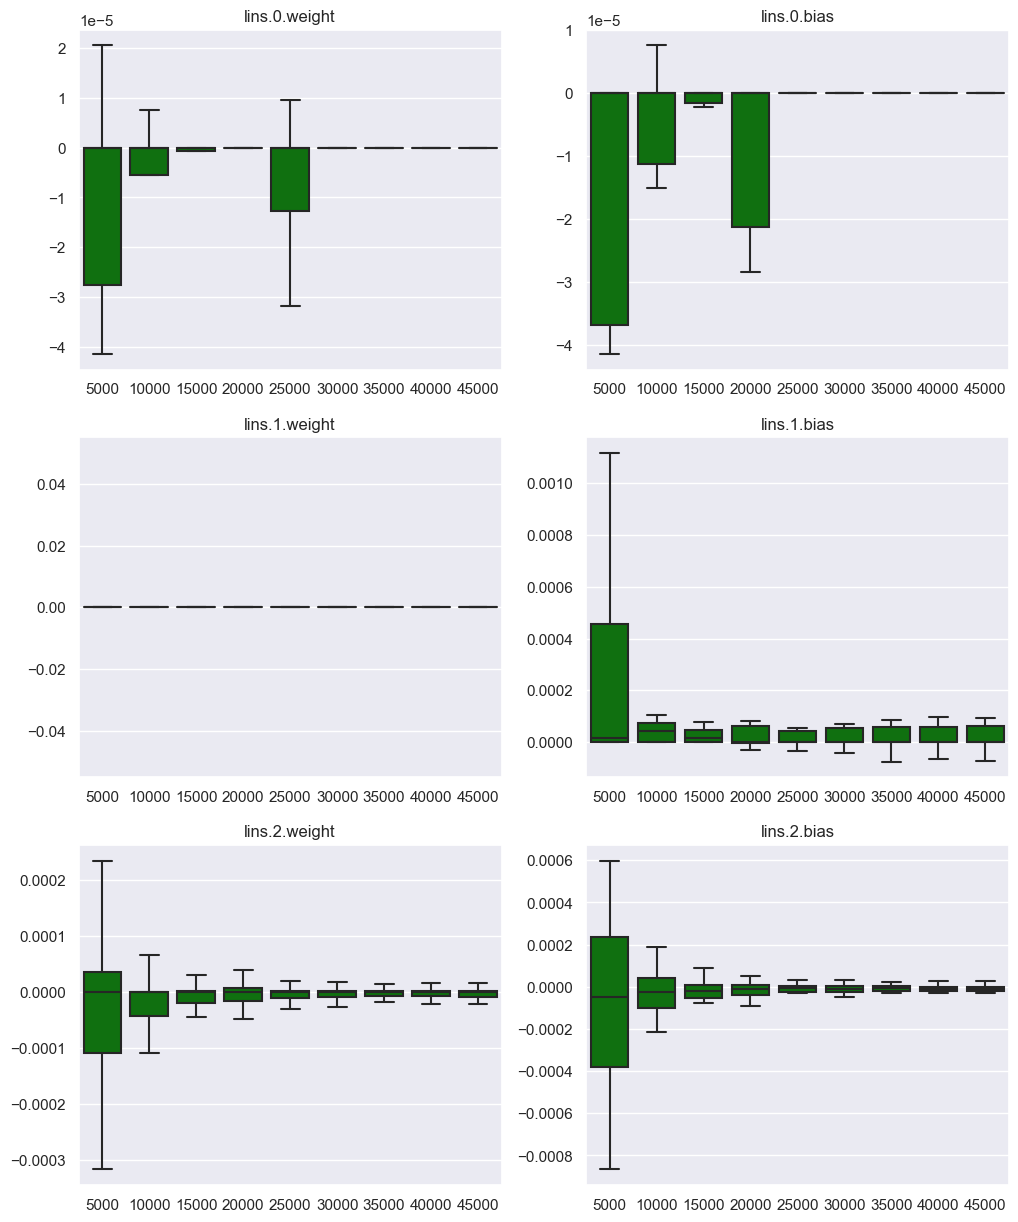

In [119]:
ncols = 2
nrows = (len(grads) + 1) // ncols
fig, axs = plt.subplots(
    ncols=ncols,
    nrows=nrows,
    figsize=(12, 5 * nrows)
)
axs = axs.flatten()

for idx, (name, df) in enumerate(grads.items()):
    sns.boxplot(
        data=df[
            (df['epoch'] % (epochs // 10) == 0)
            # (df['epoch'] <= 100) & (df['epoch'] % (epochs // 100) == 0)
        ],
        x='epoch', y='val',
        color='green',
        showfliers=False,
        ax=axs[idx],
    )

    axs[idx].set(ylabel='', xlabel='', title=name)

[Text(0.5, 1.0, 'validation'), Text(0.5, 0, '$i$')]

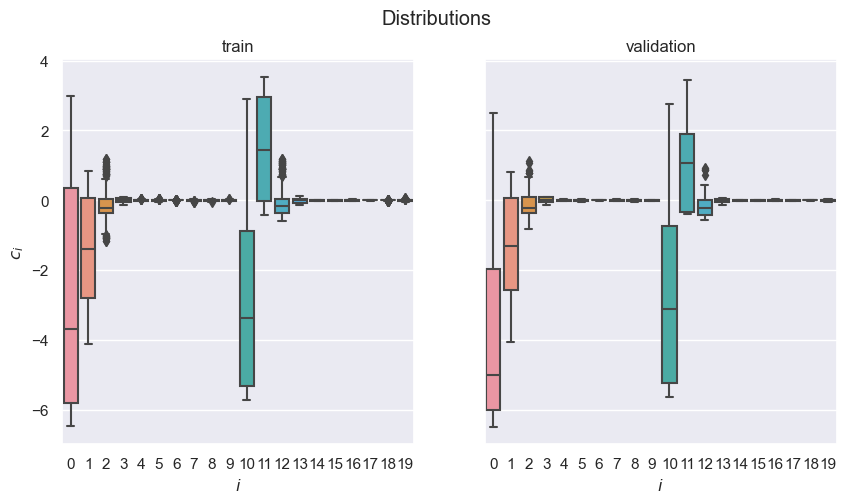

In [120]:
model.eval()
c_trn_ = model(torch.tensor(y_trn.T)).detach().numpy()
c_val_ = model(torch.tensor(y_val.T)).detach().numpy()

fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10, 5))
sns.boxplot(pd.DataFrame(c_trn_), ax=axs[0])
sns.boxplot(pd.DataFrame(c_val_), ax=axs[1])
fig.suptitle('Distributions')
axs[0].set(title='train', xlabel='$i$', ylabel='$c_i$')
axs[1].set(title='validation', xlabel='$i$')

## Evaluate

In [121]:
c_trn_ = (c_trn_[:, :L] + 1j * c_trn_[:, L:]).T
c_val_ = (c_val_[:, :L] + 1j * c_val_[:, L:]).T
S_trn_ = V @ c_trn_
S_val_ = V @ c_val_

E_trn = S_trn - S_trn_
E_val = S_val - S_val_

[Text(0.5, 1.0, 'validation'), Text(0.5, 0, '$i$')]

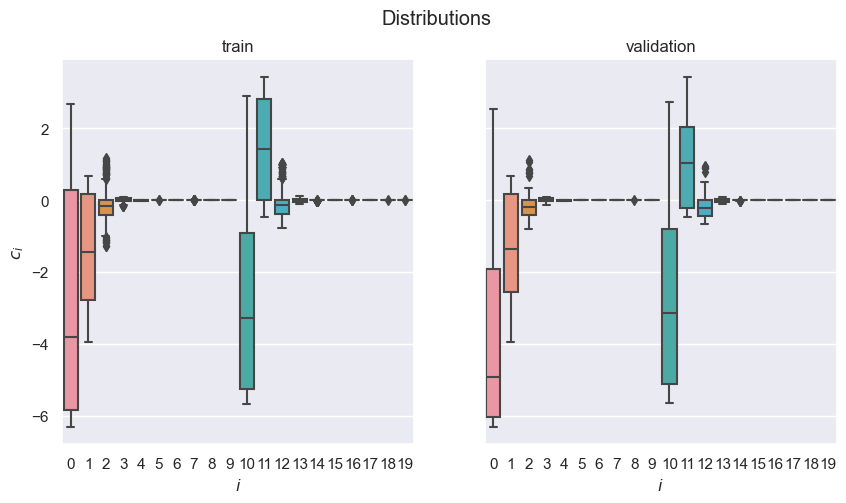

In [122]:
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10, 5))
sns.boxplot(pd.DataFrame(np.concatenate([c_trn.real, c_trn.imag]).T), ax=axs[0])
sns.boxplot(pd.DataFrame(np.concatenate([c_val.real, c_val.imag]).T), ax=axs[1])
fig.suptitle('Distributions')
axs[0].set(title='train', xlabel='$i$', ylabel='$c_i$')
axs[1].set(title='validation', xlabel='$i$')

[Text(0.5, 1.0, 'validation'), Text(0.5, 0, '$i$')]

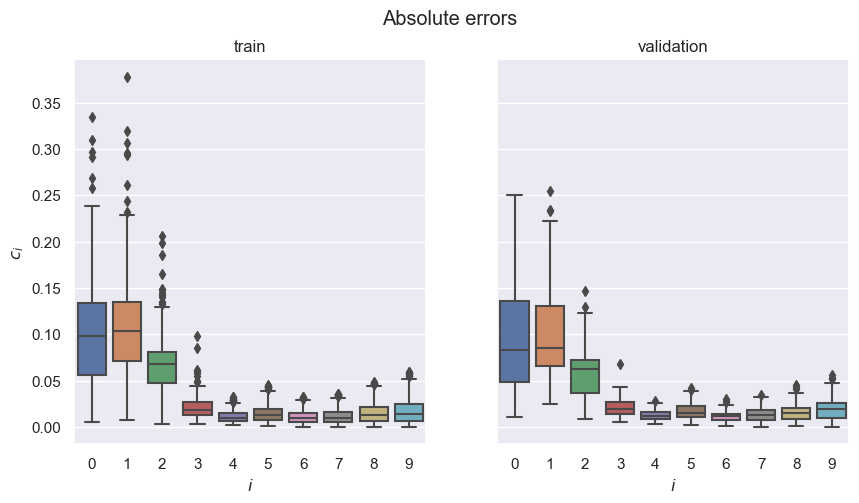

In [123]:
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10, 5))
sns.boxplot(pd.DataFrame(np.abs(c_trn - c_trn_).T), ax=axs[0])
sns.boxplot(pd.DataFrame(np.abs(c_val - c_val_).T), ax=axs[1])
fig.suptitle('Absolute errors')
axs[0].set(title='train', xlabel='$i$', ylabel='$c_i$')
axs[1].set(title='validation', xlabel='$i$')

[Text(0.5, 1.0, 'validation'), Text(0.5, 0, '$i$')]

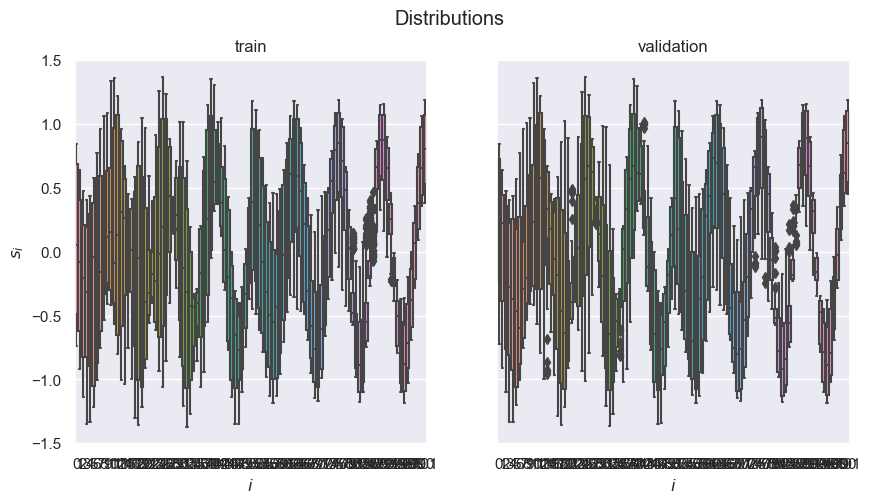

In [124]:
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10, 5))
sns.boxplot(pd.DataFrame(np.concatenate([S_trn.real, S_trn.imag]).T), ax=axs[0])
sns.boxplot(pd.DataFrame(np.concatenate([S_val.real, S_val.imag]).T), ax=axs[1])
fig.suptitle('Distributions')
axs[0].set(title='train', xlabel='$i$', ylabel='$s_i$')
axs[1].set(title='validation', xlabel='$i$')

[Text(0.5, 1.0, 'validation'), Text(0.5, 0, '$i$')]

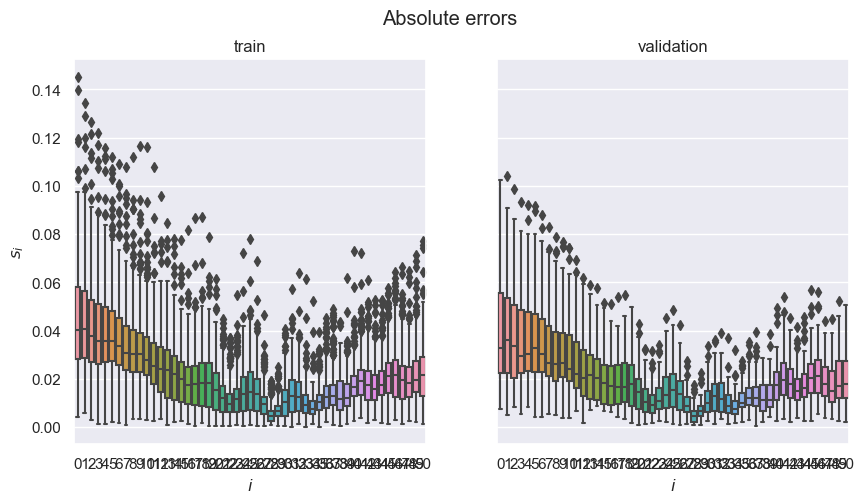

In [125]:
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10, 5))
sns.boxplot(pd.DataFrame(np.abs(S_trn - S_trn_).T), ax=axs[0])
sns.boxplot(pd.DataFrame(np.abs(S_val - S_val_).T), ax=axs[1])
fig.suptitle('Absolute errors')
axs[0].set(title='train', xlabel='$i$', ylabel='$s_i$')
axs[1].set(title='validation', xlabel='$i$')

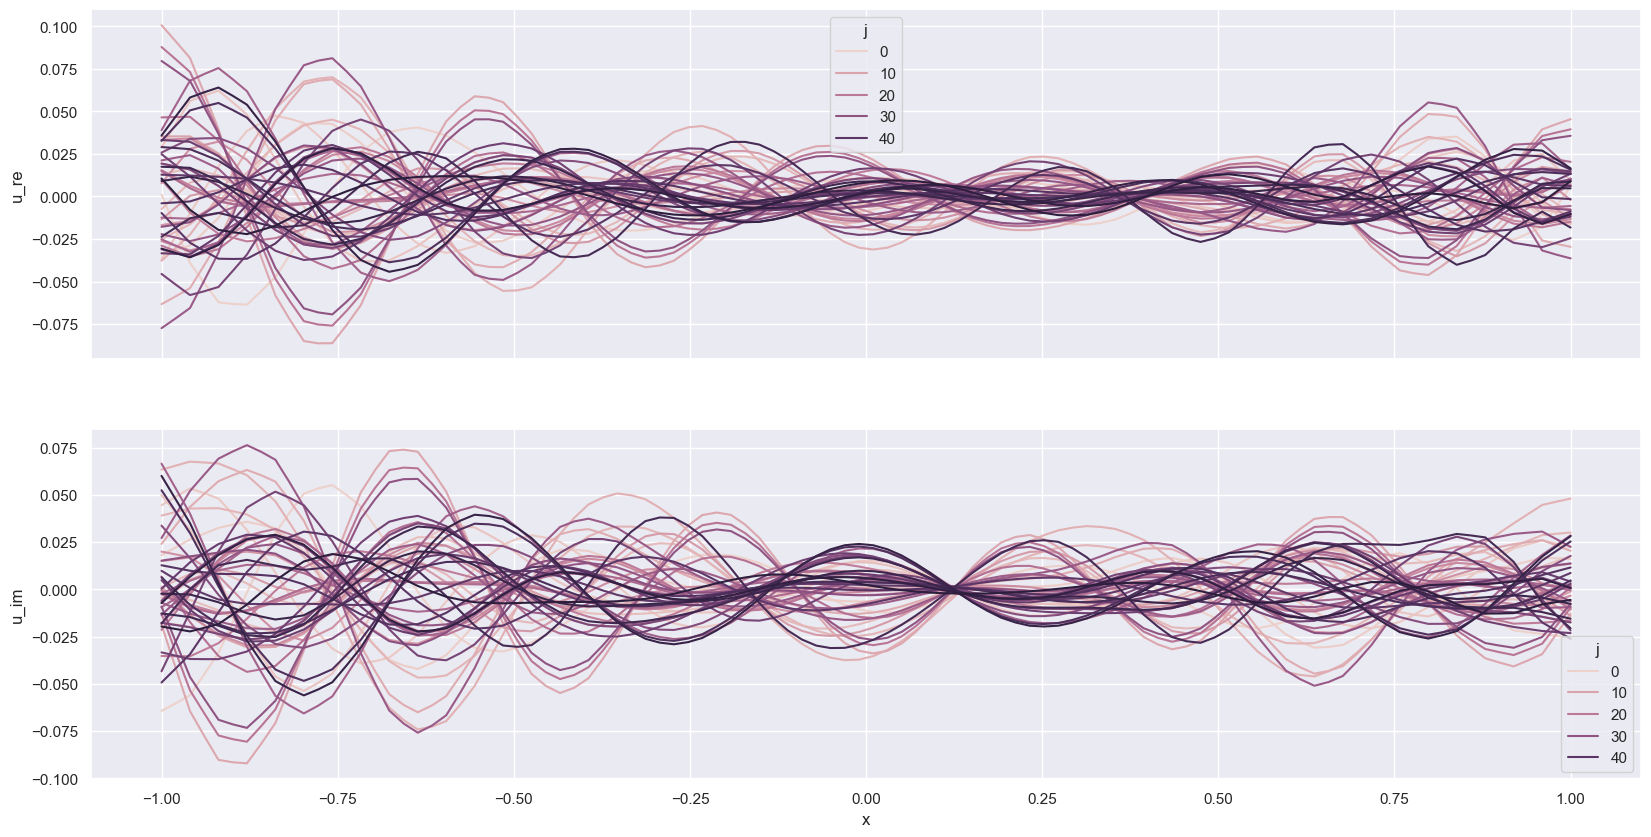

In [126]:
plot_bases(S=(S_val - S_val_), bases=solver.bases)

In [127]:
def H1_error(e: Callable, e_x: Callable) -> float:

    u2 = lambda x: abs(e(x)) ** 2
    ux2 = lambda x: abs(e_x(x)) ** 2

    err_u = np.sqrt(solver.intg(u2))
    err_u_x = np.sqrt(solver.intg(ux2))

    return err_u + err_u_x, err_u, err_u_x


In [128]:
E = E_val

errs = []
for j in range(E.shape[1]):
    err, err_u, err_u_x = H1_error(
        e=get_sol(u=E[:, j], bases=solver.bases),
        e_x=get_der(u=E[:, j], bases=solver.bases),
    )
    errs.append(err)
print(f'{np.array(errs).mean():.2e}')

4.40e-01
